In [19]:
import pandas as pd
import datetime
import numpy as np

In [20]:
#Traemos los dataframes que vamos a utilizar a lo largo del trabajo#

df_dolar = pd.read_excel(r'C:\Users\admin\Desktop\dolar.xlsx') #Aquí es donde se debería cambiar la ruta.
datos = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-economia-y-finanzas/buenos-aires-compras/bac_anual.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_14908\218604262.py:4: DtypeWarning: Columns (23,24,25,28,109,110,111,112) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-economia-y-finanzas/buenos-aires-compras/bac_anual.csv")


In [21]:
# Convierto a str la columna "date" del df_dolar y de datos para poder armar la columna de valores en moneda homogenea 
# De esta forma, podemos hacer el merge entre los dos dataframes y podemos unificar la moneda de los presupuestos estipulados
str_date =[]
for i in df_dolar["date_dolar"]:
    str_date.append(str(i)[0:10])

df_dolar["str_date"]=str_date

str_datos_dates = []

for i in datos["date"]:
        str_datos_dates.append(str(i[0:10]))

datos["str_date"]=str_datos_dates

datos = pd.merge(datos, df_dolar, on = "str_date", how='left')

valor_moneda_homogenea = []

for i,j,k in zip(datos["tender/value/amount"], datos["dolar"],datos["tender/value/currency"]):
    if str(k) == "ARS":
        valor_moneda_homogenea.append(i)
    elif str(k) == "USD":
        valor_moneda_homogenea.append(i*j)
    elif str(k) == "EUR":
        valor_moneda_homogenea.append(i*j*1.12) #Para el caso del Euro, usamos 1.12 vs. Dolar ya que es un ratio que podemos tomar como referencia, ya que no tenemos la serie del Euro


# Agregamos la nueva columna de moneda homogenea al DataFrame
datos["valor_moneda_homogenea"] = valor_moneda_homogenea

In [22]:
# completamos las celdas vacías en las reparticiones con un genérico #
for index, i in enumerate(datos["tender/procuringEntity/name"]):
    if str(i) == "nan":
        datos["tender/procuringEntity/name"][index] = "MINISTERIO DE GOBIERNO"


# pasamos el status de las licitaciones a str para luego poder armar un nuevo DataFrame#
for index, i in enumerate(datos["tender/status"]):
    datos["tender/status"][index] = str(i)

C:\Users\admin\AppData\Local\Temp\ipykernel_14908\2321381004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["tender/procuringEntity/name"][index] = "MINISTERIO DE GOBIERNO"
C:\Users\admin\AppData\Local\Temp\ipykernel_14908\2321381004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["tender/status"][index] = str(i)


In [23]:
# Preparo el df para la consigna 1 con el status = Complete
# Decidí tomar este status ya que en la consigna se especifican montos operados

datos_1_consigna = datos.drop(datos[ datos['tender/status'] != "complete" ].index)

In [24]:
### CONSIGNA 1 ###

datos_por_reparticion = datos_1_consigna.groupby(["tender/procuringEntity/name"])["valor_moneda_homogenea"].sum()

datos_por_reparticion.sort_values(inplace=True, ascending=False)

datos_por_reparticion = datos_por_reparticion.reset_index()

datos_por_reparticion["porcentaje_sobre_total"] = [str(i/datos_por_reparticion["valor_moneda_homogenea"].sum()*100) + "%" for i in datos_por_reparticion["valor_moneda_homogenea"]]

display(datos_por_reparticion)


,tender/procuringEntity/name,valor_moneda_homogenea,porcentaje_sobre_total
0,MINISTERIO DE EDUCACION,1.805314e+12,81.76652714520917%
1,AGENCIA SISTEMAS DE INFORMACION,2.332860e+11,10.566024633923355%
2,ADMINIST. GUBERNAMENTAL DE INGRESOS PUBLICOS,4.324370e+10,1.9585999415772708%
3,PLAN DE SEGURIDAD PUBLICA,4.062359e+10,1.8399296396966012%
4,MINISTERIO DE ESPACIO PUBLICO E HIGIENE URBANA,2.621815e+10,1.1874761146253083%
...,...,...,...
81,"DIRECCION GENERAL PROMOCION DEL LIBRO, BIBILIO...",1.350000e+06,6.114439252004771e-05%
82,MINISTERIO DE JUSTICIA Y SEGURIDAD,1.750000e+05,7.926124956302482e-06%
83,HTAL. PEDRO LAGLEYZE,6.950700e+03,3.1481209562155233e-07%
84,Direccion General Concesiones y Permisos,0.000000e+00,0.0%


La tabla muestra que en las primeras 5 reparticiones concentran más del 97% de las compras de CABA.

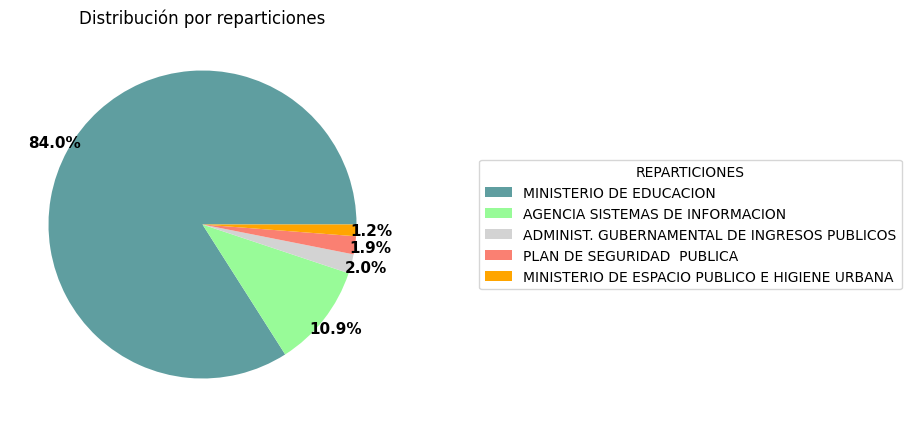

In [25]:

from matplotlib import pyplot as plt

# Grafico el % sobre los primeros 5 datos para visualizar mejor la información

fig, ax = plt.subplots(figsize=(8, 5))

labels = datos_por_reparticion["tender/procuringEntity/name"][0:5]

colors = ["cadetblue", "palegreen", "lightgrey", "salmon", "orange"]

def func(pct, total):
    absolute = int(pct/100.*np.sum(total))
    return "{:.1f}%".format(pct, absolute)

wedges, texts, autotexts = ax.pie(datos_por_reparticion["valor_moneda_homogenea"][0:5], 
                                autopct=lambda pct: func(pct, datos_por_reparticion["valor_moneda_homogenea"][0:5]),colors = colors,
                                textprops=dict(color="black"), pctdistance=1.1)

ax.legend(wedges, labels,
          title="REPARTICIONES",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 1, 1))

plt.setp(autotexts, size=11, weight="bold")

plt.title("Distribución por reparticiones", loc="center")

plt.show()

Tomando los primeros 5 datos, el gráfico muestra que el Ministerio de Educación es la repartición que mayor presupuesto demanda en materia de compras/licitaciones acaparando el 84% de los mismos, seguido de la Agencia de Sistemas de Información.

In [26]:
datos_por_rubro = datos_1_consigna.groupby(["tender/additionalProcurementCategories"])["valor_moneda_homogenea"].sum()

datos_por_rubro.sort_values(inplace=True, ascending=False)

datos_por_rubro = datos_por_rubro.reset_index()

datos_por_rubro["porcentaje_sobre_total"] = [str(i/datos_por_rubro["valor_moneda_homogenea"].sum()*100) + "%" for i in datos_por_rubro["valor_moneda_homogenea"]]

display(datos_por_rubro)

,tender/additionalProcurementCategories,valor_moneda_homogenea,porcentaje_sobre_total
0,Alimentación y Gastronomía,1.802038e+12,81.61816397560855%
1,Informática,2.951258e+11,13.366881094544658%
2,Servicios,3.019292e+10,1.3675019657319492%
3,Salud,2.517024e+10,1.1400141932240162%
4,Textil Confección y Calzado,2.246259e+10,1.0173787811136914%
5,Artes Gráficas Duplicación y Equipamiento para...,1.225192e+10,0.5549157440216618%
6,Construcción,1.221493e+10,0.5532405761475994%
7,Cultura Deporte y Recreación,3.591502e+09,0.162666832364705%
8,Perfumería Limpieza y Contenedores Comerciales...,1.433247e+09,0.06491484184476466%
9,Reservado para GCBA,9.409540e+08,0.042617822030369415%


Similarmente a lo que sucede con el caso de reparticiones, en el caso de los rubros también se encuentra muy concentrado entre el rubro de alimentación y gastronomía (destinado al Ministerio de Educación) y el de Informática (destinado a la Agencia de Sistemas de Información).

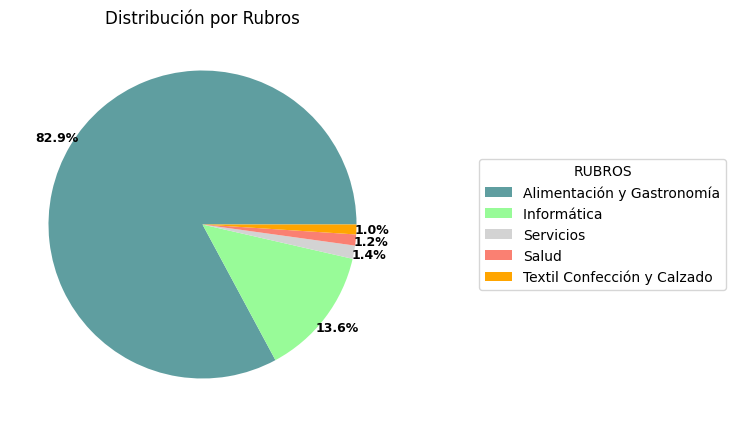

In [27]:
# Graficamos sobre los 5 primeros valores como hicimos para el caso de reparticiones #

datos_para_grafico_2 = datos_por_rubro["valor_moneda_homogenea"][0:5]

fig_2, ax_2 = plt.subplots(figsize=(8, 5))

labels_2 = datos_por_rubro["tender/additionalProcurementCategories"][0:5]

wedges_2, texts_2, autotexts_2 = ax_2.pie(datos_para_grafico_2, 
                                autopct=lambda pct: func(pct, datos_para_grafico_2),colors = colors,
                                textprops=dict(color="black"),pctdistance=1.1)

ax_2.legend(wedges_2, labels_2,
          title="RUBROS",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 1, 1))

plt.setp(autotexts_2, size=9, weight="bold")

plt.title("Distribución por Rubros", loc="center")

plt.show()

Ahora veamos si es que nuestra hipótesis acerca de si Ministerio de Educacion --> Alimentación y Gastronomía, y, por otro lado, si Agencia de Sistemas de Información --> compras informáticas

In [28]:
datos_por_rubro_y_reparticion = datos_1_consigna.groupby(["tender/additionalProcurementCategories", "tender/procuringEntity/name"])["valor_moneda_homogenea"].sum()

datos_por_rubro_y_reparticion = datos_por_rubro_y_reparticion.reset_index()

datos_por_rubro_y_reparticion["porcentaje_sobre_total"] = [str(i/datos_por_rubro_y_reparticion["valor_moneda_homogenea"].sum()*100) + "%" for i in datos_por_rubro_y_reparticion["valor_moneda_homogenea"]]

datos_por_rubro_y_reparticion.sort_values(by="valor_moneda_homogenea",inplace=True, ascending=False)

display(datos_por_rubro_y_reparticion)


,tender/additionalProcurementCategories,tender/procuringEntity/name,valor_moneda_homogenea,porcentaje_sobre_total
20,Alimentación y Gastronomía,MINISTERIO DE EDUCACION,1.802008e+12,81.61680516522294%
200,Informática,AGENCIA SISTEMAS DE INFORMACION,2.332251e+11,10.56326298212392%
197,Informática,ADMINIST. GUBERNAMENTAL DE INGRESOS PUBLICOS,4.119700e+10,1.8659002357523682%
456,Servicios,MINISTERIO DE ESPACIO PUBLICO E HIGIENE URBANA,2.599413e+10,1.1773298001823636%
488,Textil Confección y Calzado,PLAN DE SEGURIDAD PUBLICA,2.239153e+10,1.0141604301611487%
...,...,...,...,...
472,Textil Confección y Calzado,DIR. GRAL CENTRO CULTURAL RECOLETA,0.000000e+00,0.0%
473,Textil Confección y Calzado,DIR.GRAL.DE COMPRAS Y CONTRATACIONES,0.000000e+00,0.0%
148,Cultura Deporte y Recreación,UPE URBANIZACION BARRIO PADRE CARLOS MUGICA,0.000000e+00,0.0%
51,Comunicaciones,PLAN DE SEGURIDAD PUBLICA,0.000000e+00,0.0%


Tal y como pensabamos, las compras del Ministerio de Educación corresponden en su totalidad (o casi) al sector de Alimentación y Gastronomía, mientras lo propio hace la Agencia de Sistemas de Información con los materiales informáticos.

In [29]:
#CONSIGNA 2#

#En el caso de la Consigna número 2, decidí tomar sólo las adjudicaciones (licitaciones activas), en donde se encuentran datos de las empresas proveedoras.

valor_moneda_homogenea_adjudicaciones = []

for i,j,k in zip(datos["awards/0/value/amount"], datos["dolar"],datos["tender/value/currency"]):
    if str(k) == "ARS":
        valor_moneda_homogenea_adjudicaciones.append(i)
    elif str(k) == "USD":
        valor_moneda_homogenea_adjudicaciones.append(i*j)
    elif str(k) == "EUR":
        valor_moneda_homogenea_adjudicaciones.append(i*j*1.12)


datos["valor_moneda_homogenea_adjudicaciones"] = valor_moneda_homogenea_adjudicaciones

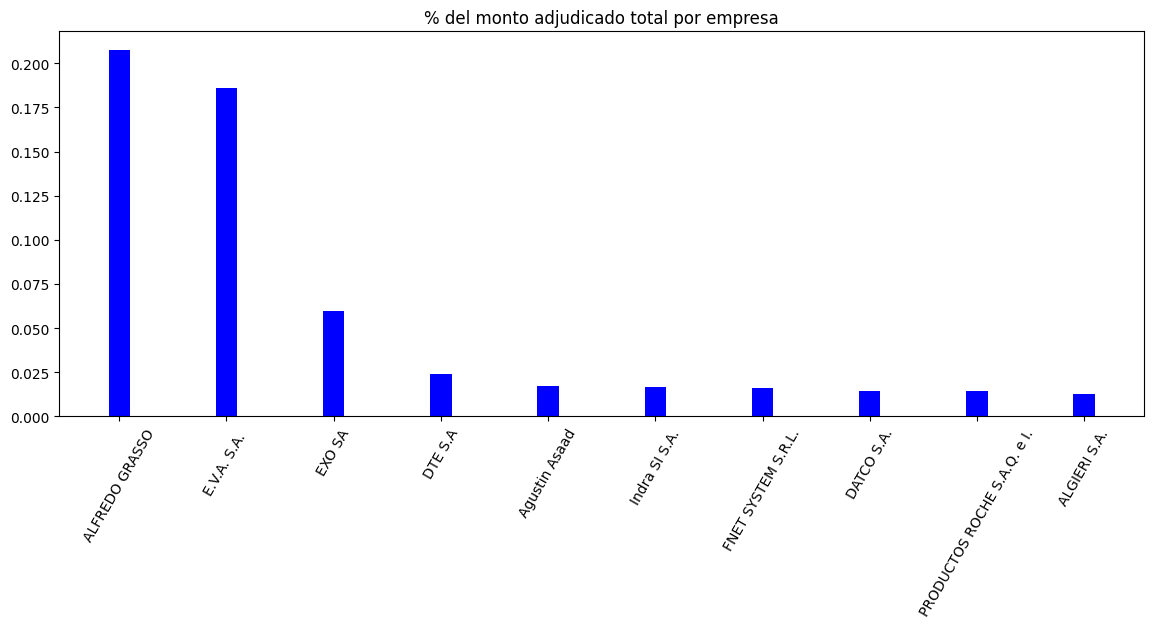

In [30]:
datos_por_empresa = datos.groupby(["awards/0/suppliers/0/name"])["valor_moneda_homogenea_adjudicaciones"].sum()

datos_por_empresa.sort_values(inplace=True, ascending=False)

datos_por_empresa = datos_por_empresa.reset_index()

porcentaje_sobre_total_adjudicado = []

for i in datos_por_empresa["valor_moneda_homogenea_adjudicaciones"]:
    porcentaje_sobre_total_adjudicado.append(i/datos_por_empresa["valor_moneda_homogenea_adjudicaciones"].sum())

datos_por_empresa["porcentaje_sobre_total_adjudicado"] = porcentaje_sobre_total_adjudicado

datos_para_grafico_3 = datos_por_empresa["porcentaje_sobre_total_adjudicado"][0:10]
labels_3 = datos_por_empresa["awards/0/suppliers/0/name"][0:10]

fig_3, ax_3 = plt.subplots(figsize=(14, 5))
plt.bar(labels_3, datos_para_grafico_3, color = "blue", width=0.2)
plt.xticks(fontsize=10,rotation=60)

plt.title("% del monto adjudicado total por empresa")
plt.show()



En el gráfico, se puede observar como apenas 4 empresas acaparan el 48% de las provisiones. Sin embargo, sería conveniente analizar la relación entre empresas y rubros. Para ello, armaremos un dataset agrupando estas dos variables.

In [31]:
datos_por_rubro_y_empresas = datos.groupby(["tender/additionalProcurementCategories", "awards/0/suppliers/0/name"])["valor_moneda_homogenea_adjudicaciones"].sum()

datos_por_rubro_y_empresas = datos_por_rubro_y_empresas.reset_index()

datos_por_rubro_y_empresas["porcentaje_sobre_total"] = [str(i/datos_por_rubro_y_empresas["valor_moneda_homogenea_adjudicaciones"].sum()*100) + "%" for i in datos_por_rubro_y_empresas["valor_moneda_homogenea_adjudicaciones"]]

datos_por_rubro_y_empresas.sort_values(by="valor_moneda_homogenea_adjudicaciones",inplace=True, ascending=False)

display(datos_por_rubro_y_empresas)

,tender/additionalProcurementCategories,awards/0/suppliers/0/name,valor_moneda_homogenea_adjudicaciones,porcentaje_sobre_total
3,Alimentación y Gastronomía,ALFREDO GRASSO,2.750563e+10,20.755919157889984%
1027,Servicios,E.V.A. S.A.,2.466033e+10,18.608832980577496%
313,Informática,EXO SA,7.929504e+09,5.98365257162052%
309,Informática,DTE S.A,3.218296e+09,2.428545826665627%
448,Perfumería Limpieza y Contenedores Comerciales...,Agustin Asaad,2.293200e+09,1.7304627689252585%
...,...,...,...,...
190,Cultura Deporte y Recreación,EDICIONES IAMIQUÉ S.A.,2.265200e+04,1.7093337973877096e-05%
148,Construcción,QUIMICA CORDOBA S.A.,1.885468e+04,1.4227857038199762e-05%
401,Laboratorio para Análisis Físico y/o Químico e...,RESAICAR SRL,1.392468e+04,1.0507648835338465e-05%
272,Ferretería,SINERGIA COLOR SA,1.200000e+04,9.055273516092403e-06%


Como se puede ver en la tabla, la empresa de Alfredo Grasso esta totalmente vinculada al sector de Alimentación y Gastronomía, y como ya vimos anteriormente, también al Ministerio de Educación.

,tender/procurementMethodDetails,valor_moneda_homogenea,porcentaje_total
0,LICITACION PUBLICA,2.223872e+12,91.11206466795562%
1,CONTRATACION DIRECTA,1.867227e+11,7.650030261613761%
2,CONCURSO PUBLICO,2.595824e+10,1.0635091788560407%
3,CONTRATACION MENOR,4.061104e+09,0.16638347897326444%
4,LICITACION PRIVADA,1.955678e+08,0.008012412601333124%


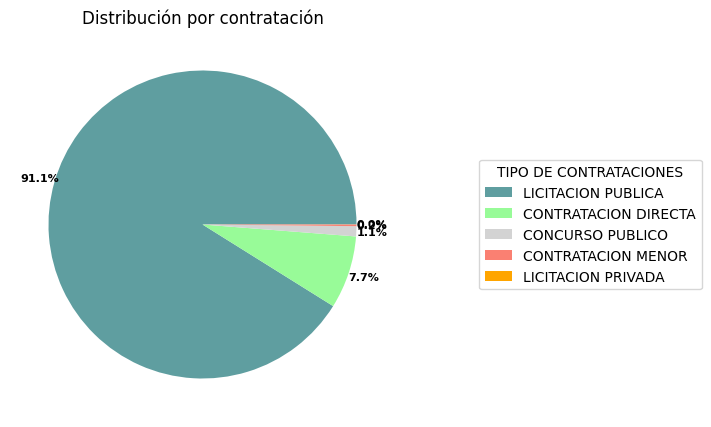

In [32]:
#CONSIGNA 3#

datos_por_contratacion = datos.groupby(["tender/procurementMethodDetails"])["valor_moneda_homogenea"].sum()

datos_por_contratacion.sort_values(inplace=True, ascending=False)

datos_por_contratacion = datos_por_contratacion.reset_index()

datos_para_grafico_4 = datos_por_contratacion["valor_moneda_homogenea"]

porcentaje_total = []
for i in datos_por_contratacion["valor_moneda_homogenea"]:
    j = i/datos_por_contratacion["valor_moneda_homogenea"].sum()*100
    j = str(j) + "%"
    porcentaje_total.append(j)

datos_por_contratacion["porcentaje_total"] = porcentaje_total

display(datos_por_contratacion)

fig_4, ax_4 = plt.subplots(figsize=(8, 5))

labels_4 = datos_por_contratacion["tender/procurementMethodDetails"]

wedges, texts, autotexts = ax_4.pie(datos_para_grafico_4, 
                                autopct=lambda pct: func(pct, datos_por_reparticion["valor_moneda_homogenea"][0:5]),colors = colors,
                                textprops=dict(color="black"), pctdistance=1.1)

ax_4.legend(wedges, labels_4,
          title="TIPO DE CONTRATACIONES",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 1, 1))

plt.setp(autotexts, size=8, weight="bold")

plt.title("Distribución por contratación", loc="center")

plt.show()


En el caso de Distribución por contratación, vemos como la Licitación pública es la que absorve más del 91% de las licitaciones, quedando en segundo lugar las conrtataciones directas, y ya poco queda para el resto.

In [33]:
#CONSIGNA 4#

# Cambiamos el formato fecha como dice la consigna, y también para poder utilizarla en un grafico #

def convert_date(date):
     
        format = '%Y-%m-%d'
        date = str(date[0:10])
        
        new_date = datetime.datetime.strptime(date, format)

        return new_date

for index, i in enumerate(datos["date"]):
        new_dates = convert_date(i) 
        datos["date"][index] = new_dates

C:\Users\admin\AppData\Local\Temp\ipykernel_14908\4243177891.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["date"][index] = new_dates


In [34]:
#Agregamos la columna de licitaciones_completas_monto para aquellas compras donde la operación ya haya sido completada y poder trackear la evolución.

licitaciones_completas_monto = []

for i,j in zip(datos["tender/status"], datos["valor_moneda_homogenea"]):
    if i == "complete":
        licitaciones_completas_monto.append(j)
    elif i != "complete":
        licitaciones_completas_monto.append(0)

datos["licitaciones_completas_monto"] = licitaciones_completas_monto

C:\Users\admin\AppData\Local\Temp\ipykernel_14908\266504313.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  evolucion_presupuesto = datos.groupby(["date"])["valor_moneda_homogenea", "licitaciones_completas_monto"].sum()


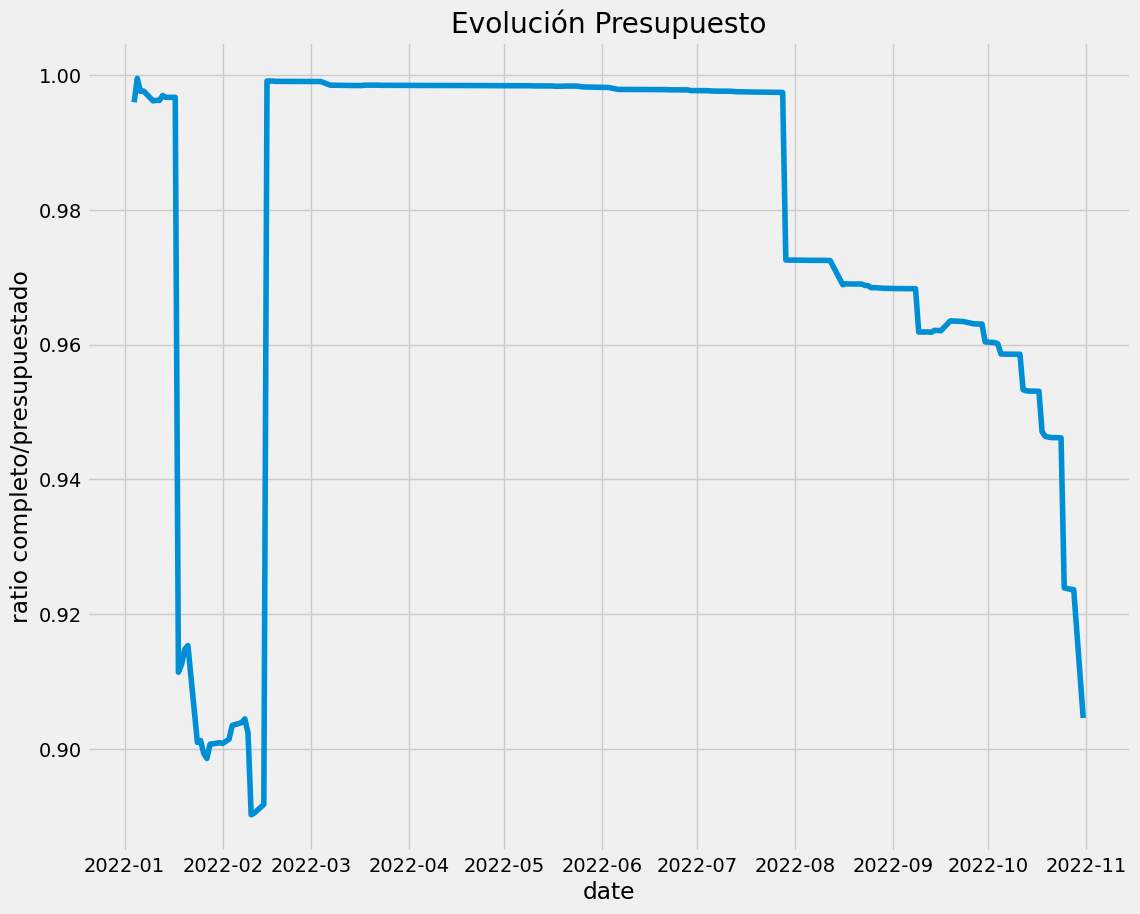

In [35]:
evolucion_presupuesto = datos.groupby(["date"])["valor_moneda_homogenea", "licitaciones_completas_monto"].sum()

#Cramosa la función acumula_valores, que es una lista donde se acumulan los valores anteriores + el actual
#Para luego dividirlo por el total y ver el ratio entre lo que efectivamente se gastó y lo que se presupuestó
#No tomé en cuenta en este caso las licitaciones que estaban activas, ya que desconozco cuán completo está

def acumula_valores(lista):
    valores_acumulados = []
    length = len(lista)
    valores_acumulados = [sum(lista[0:i:1]) for i in range(0, length+1)]
    return valores_acumulados[1:]

evolucion_presupuesto["total_acumulados"] = acumula_valores(evolucion_presupuesto["valor_moneda_homogenea"])
evolucion_presupuesto["completos_acumulados"] = acumula_valores(evolucion_presupuesto["licitaciones_completas_monto"])

evolucion_presupuesto["ratio_completo_presupuestado"] = [j/i for i,j in zip(evolucion_presupuesto["total_acumulados"], 
                                                                            evolucion_presupuesto["completos_acumulados"])]


plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 10))
plt.xlabel("date")
plt.ylabel("ratio completo/presupuestado")
plt.title("Evolución Presupuesto")
 
plt.plot(evolucion_presupuesto["ratio_completo_presupuestado"][1:])


En este caso, vemos como rara vez el la tasa de compras completadas cae por debajo del 90% en lo que va del 2022, aunque la tendencia en los últimos meses es de caída.